<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/histone_doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 9.0MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# module auto reload
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


In [3]:
# copy modules
!cp -r '/content/drive/My Drive/dna_NN_theory/reading_dna_scripts' .
!ls reading_dna_scripts

download.py  load.py


In [4]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

from reading_dna_scripts.load import read_fasta

In [5]:
DIR = '/content/drive/My Drive/'
DATA_DIR = DIR + 'dna_NN_theory/histone/'
MODEL_DIR = DIR + 'dna_NN_theory/models/'

In [6]:
file = DIR + 'H3.fasta'
sequences, labels = read_fasta(file)
seq_len = len(sequences[0])

14963 samples loaded


In [7]:
def n_gram(x, word_size=3):
  arr_x = [c for c in x]
  words = tf.strings.ngrams(arr_x, ngram_width=word_size, separator='').numpy()
  words = list(pd.Series(words).apply(lambda b: b.decode('utf-8')))
  return words

In [8]:
df = pd.DataFrame(sequences, columns=['sequence'])
df['ngram'] = df['sequence'].apply(n_gram)
df.head()
# sequences = list(df.ngram)
# sequences[0]

,sequence,ngram
0,AATTTTTATAGGTCGACCCTTCTGTCGCTTACTGGGTTGATTATCT...,"[AAT, ATT, TTT, TTT, TTT, TTA, TAT, ATA, TAG, ..."
1,AATTATATTTCCATCAGCTCAATACCGCAGTACTTTGAAACCTGAT...,"[AAT, ATT, TTA, TAT, ATA, TAT, ATT, TTT, TTC, ..."
2,AACAATAGTGGGTATGAGTAAAGATATATAGATCGATATTTTGAAT...,"[AAC, ACA, CAA, AAT, ATA, TAG, AGT, GTG, TGG, ..."
3,CAAAGATTTCAACCATAGTAGGTATGCCCCAGATGAAACATTACTG...,"[CAA, AAA, AAG, AGA, GAT, ATT, TTT, TTC, TCA, ..."
4,CACAATAGCGTCAATAATAAAGTTCCATCTCCATCCCTCTAAACCA...,"[CAC, ACA, CAA, AAT, ATA, TAG, AGC, GCG, CGT, ..."


In [9]:
# split
SEED = 3264
test_size = 0.15
val_size = 0.15

split_options = dict(test_size=test_size, stratify=labels, random_state=SEED)
x_train_val, xtest, y_train_val, ytest = train_test_split(df, labels, **split_options)
# normalize val_size and update options
split_options.update(dict(test_size=val_size/(1-test_size), stratify=y_train_val))
xtrain, xval, ytrain, yval = train_test_split(x_train_val, y_train_val, **split_options)
del x_train_val, y_train_val

print('train size:', len(xtrain))
print('val size: ', len(xval))
print('test size: ', len(xtest))
print("The length of the sequence is", seq_len)

train size: 10473
val size:  2245
test size:  2245
The length of the sequence is 500


In [10]:
xtrain['label'] = ytrain
xval['label'] = yval
xtest['label'] = ytest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
ytrain = np.array(ytrain)
yval = np.array(yval)
ytest = np.array(ytest)

In [12]:
# saving current model
DATE = '_20210311'
SUFFIX = "doc2vec_histone"

In [13]:
import multiprocessing
from tqdm import tqdm
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from gensim.test.utils import get_tmpfile

xtrain_tagged = xtrain.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["label"]]), axis=1
)
xval_tagged = xval.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["label"]]), axis=1
)
xtest_tagged = xtest.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["label"]]), axis=1
)

In [14]:
tqdm.pandas(desc="progress-bar")

cores = multiprocessing.cpu_count()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [31]:
def getVec(model, tagged_docs, epochs=20):
  sents = tagged_docs.values
  regressors = [model.infer_vector(doc.words, epochs=epochs) for doc in sents]
  return np.array(regressors)

def doc2vec_training(embed_size_list=[50,100,150,200], figsize=(10,50), verbose=0):
  num_model = len(embed_size_list)
  # fig, axes = plt.subplots(num_model, 2, figsize=figsize)
  counter = 0
  model_list = []
  hist_list = []
  es_cb = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
  for embed_size in embed_size_list:
    start = time.time()
    print("training doc2vec for embedding size =", embed_size)
    model_dm = Doc2Vec(dm=1, vector_size=embed_size, negative=5, hs=0, \
                min_count=2, sample=0, workers=cores)
    if verbose == 1:
      model_dm.build_vocab([x for x in tqdm(xtrain_tagged.values)])
    else:
      model_dm.build_vocab(xtrain_tagged.values)

    for epoch in range(80):
      if verbose == 1:
        model_dm.train([x for x in tqdm(xtrain_tagged.values)], \
              total_examples=len(xtrain_tagged.values), epochs=1)
      else:
        model_dm.train(xtrain_tagged.values, \
              total_examples=len(xtrain_tagged.values), epochs=1)
      model_dm.alpha -= 0.002 
      model_dm.min_alpha = model_dm.alpha
    xtrain_vec = getVec(model_dm, xtrain_tagged)
    xval_vec = getVec(model_dm, xval_tagged)
    xtest_vec = getVec(model_dm, xtest_tagged)
    # save the embedding to csv files
    train_filename = "size" + str(embed_size) + "_train.csv"
    val_filename = "size" + str(embed_size) + "_val.csv"
    test_filename = "size" + str(embed_size) + "_test.csv"
    np.savetxt(DATA_DIR + train_filename, xtrain_vec, delimiter=",")
    np.savetxt(DATA_DIR + val_filename, xval_vec, delimiter=",")
    np.savetxt(DATA_DIR + test_filename, xtest_vec, delimiter=",")
    print("the shape for training vector is", xtrain_vec.shape, \
      "the shape for val vector is", xval_vec.shape, \
      "the shape for test vector is", xtest_vec.shape)
    # xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec)
    # xval_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xval_vec)
    # xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec)
    # plotVec(axes[counter, 0], xtrain_tsne, ytrain, title="TSNE, training, embedding="+str(embed_size))
    # plotVec(axes[counter, 0], xtrain_tsne, ytrain, title="TSNE, training, embedding="+str(embed_size))
    # plotVec(axes[counter, 1], xtest_tsne, ytest, title="TSNE, test, embedding="+str(embed_size))
    counter += 1

    print("embedding size =", embed_size)
    model = keras.Sequential([
      keras.layers.Dense(128, activation="relu", input_shape=[embed_size]),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(64, activation="relu"), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(32, activation="relu"), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(16, activation="relu"), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation="sigmoid")                        
    ])
    model.compile(keras.optimizers.SGD(momentum=0.9), \
          "binary_crossentropy", metrics=["accuracy"])
    hist = model.fit(xtrain_vec, ytrain, \
          epochs=1000, callbacks=[es_cb], validation_data=(xval_vec, yval ))
    train_loss, train_acc = model.evaluate(xtrain_vec, ytrain)
    val_loss, val_acc = model.evaluate(xval_vec, yval)
    test_loss, test_acc = model.evaluate(xtest_vec, ytest)
    print("Evaluation on training set: loss", train_loss, \
          "accuracy", train_acc)
    print("Evaluation on val set: loss", val_loss, \
          "accuracy", val_acc)
    print("Evaluation on test set: loss", test_loss, \
          "accuracy", test_acc)
    model_list.append(model)
    # fname = get_tmpfile(MODEL_DIR+"histone_doc2vec_"+embed_size)
    # model.save(fname)
    model.save(MODEL_DIR+SUFFIX+str(embed_size)+"_"+DATE+".h5")
    hist_list.append(hist)
    save_hist(hist, SUFFIX + "_size" + str(embed_size) )
    end = time.time()
    print("running time in ", end - start, "seconds")
    print("\n\n")
  
  return model_list, hist_list

def save_hist(hist, suffix):
  filename = DIR + 'dna_NN_theory/histone/' + suffix + "_history.csv"
  hist_df = pd.DataFrame(hist.history) 
  with open(filename, mode='w') as f:
    hist_df.to_csv(f)

def save_prediction(res, suffix=""):
  i = 0
  for ds in ['train', 'val', 'test']:
    filename = DIR + 'dna_NN_theory/histone/' + suffix + "_" + ds + "_prediction.csv"
    df = pd.DataFrame()
    df[ds] = res[i]
    i += 1
    df[ds+'_pred'] = res[i]
    i += 1
    with open(filename, mode='w') as f:
      df.to_csv(f)
  
### ref: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
def plot_ROC(label, pred, title="ROC"):
  fpr, tpr, threshold = metrics.roc_curve(label, pred)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title(title)
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

### ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
def plot_recall_precision(label, pred, title="RP"):
  precision, recall, thresholds = metrics.precision_recall_curve(label, pred)
  no_skill = np.sum(label) / len(label)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='random')
  plt.plot(recall, precision, marker='.', label='model')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

def eval_model(model, ds, ds_name="Training"):
  loss, acc = model.evaluate(ds, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}%".format(ds_name, np.round(loss, 3), np.round(acc*100, 2)))

In [20]:
embed_size_list = [50,100,150,200]
num_model = len(embed_size_list)
model_list, hist_list = doc2vec_training(embed_size_list, figsize=(10,20))

training doc2vec for embedding size = 50
the shape for training vector is (10473, 50) the shape for val vector is (2245, 50) the shape for test vector is (2245, 50)
embedding size = 50
Epoch 1/1000
328/328 [==============================] - 2s 3ms/step - loss: 0.7227 - accuracy: 0.5208 - val_loss: 0.6836 - val_accuracy: 0.5746
Epoch 2/1000
328/328 [==============================] - 1s 3ms/step - loss: 0.6861 - accuracy: 0.5532 - val_loss: 0.6876 - val_accuracy: 0.5501
Epoch 3/1000
328/328 [==============================] - 1s 3ms/step - loss: 0.6899 - accuracy: 0.5451 - val_loss: 0.6810 - val_accuracy: 0.5733
Epoch 4/1000
328/328 [==============================] - 1s 3ms/step - loss: 0.6846 - accuracy: 0.5604 - val_loss: 0.6843 - val_accuracy: 0.5488
Epoch 5/1000
328/328 [==============================] - 1s 3ms/step - loss: 0.6846 - accuracy: 0.5581 - val_loss: 0.6787 - val_accuracy: 0.5733
Epoch 6/1000
328/328 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 

In [ ]:
# for i in range(len(embed_size_list)):
#   s = embed_size_list[i]
#   print("embedding size is {}".format(s))
#   train_filename = "doc2vec_viridae_size" + str(s) + "_train.csv"
#   test_filename = "doc2vec_viridae_size" + str(s) + "_test.csv"
#   training_vectors = pd.read_csv(data_path + train_filename, header=None)
#   test_vectors = pd.read_csv(data_path + test_filename, header=None)
#   ## evaluation for whole embedding
#   train_sil = silhouette_score(training_vectors, ytrain, metric='cosine')
#   test_sil = silhouette_score(test_vectors, ytest, metric='cosine')
#   print("Whole embedding, silhouette score for training/test embedding is {}/{}".format(train_sil, test_sil))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 256)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

In [ ]:
# for i in range(len(embed_size_list)):
#   s = embed_size_list[i]
#   filename = data_path + "doc2vec_histone_size" + str(s) + "_history.csv"
#   hist_df = pd.DataFrame(hist_list[i].history) 
#   with open(filename, mode='w') as f:
#     hist_df.to_csv(f)

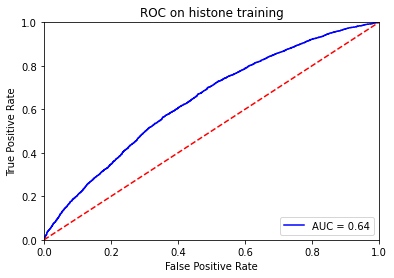

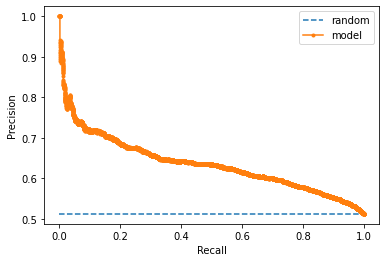

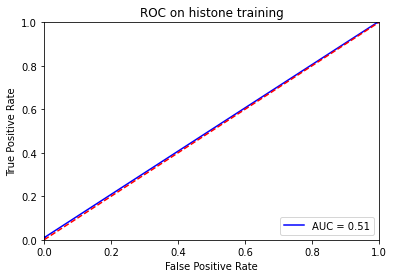

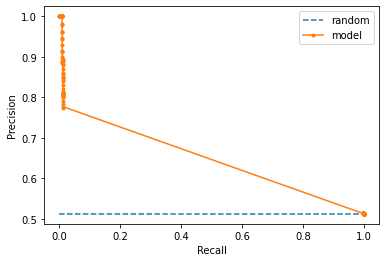

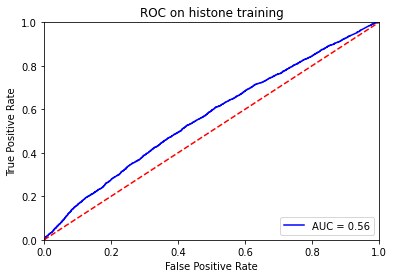

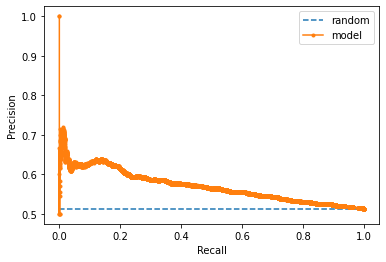

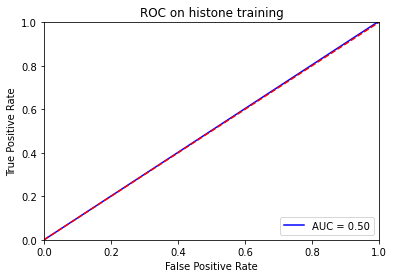

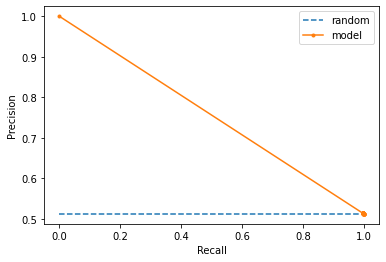

In [37]:
for i in range(len(embed_size_list)):
  s = embed_size_list[i]
  model = tf.keras.models.load_model(MODEL_DIR + "doc2vec_histone" + str(s) + "_" + DATE + ".h5")
  train_filename = "size" + str(s) + "_train.csv"
  val_filename = "size" + str(s) + "_val.csv"
  test_filename = "size" + str(s) + "_test.csv"
  xtrain_vec = pd.read_table(DATA_DIR + train_filename, delimiter=",", header=None)
  xval_vec = pd.read_table(DATA_DIR + val_filename, delimiter=",", header=None)
  xtest_vec = pd.read_table(DATA_DIR + test_filename, delimiter=",", header=None)
  ytrain_pred = model.predict(xtrain_vec)
  yval_pred = model.predict(xval_vec)
  ytest_pred = model.predict(xtest_vec)
  res = [ytrain, ytrain_pred, yval, yval_pred, ytest, ytest_pred]
  save_prediction(res, SUFFIX + "_size" + str(s) )
  plot_ROC(ytrain, ytrain_pred, title='ROC on histone training')
  plot_recall_precision(ytrain, ytrain_pred, title='precision/recall on histone training')

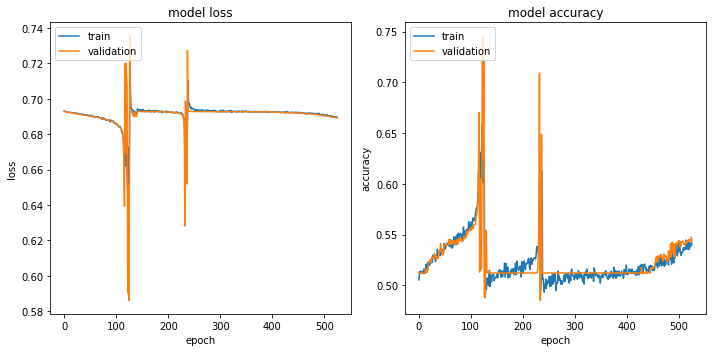

In [ ]:
# recovered_hist = []
fig, axes = plt.subplots(num_model, 2, figsize=(10, 15))
for i in range(num_model):
  s = embed_size_list[i]
  filename = data_path + "doc2vec_histone_size" + str(s) + "_history.csv"
  # hist_df = pd.read_csv(filename)
  ax1 = axes[i, 0]
  ax2 = axes[i, 1]

  ax1.plot(hist_df['loss'], label='training')
  ax1.plot(hist_df['val_loss'], label='test')
  ax1.set_ylim(0.1, 1.2)
  ax1.set_title('model loss, embedding = '+str(embed_size_list[i]))
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'test'], loc='upper left')
  
  ax2.plot(hist_df['accuracy'], label='train')
  ax2.plot(hist_df['val_accuracy'], label='test')
  ax2.set_ylim(0.5, 1.0)
  ax2.set_title('model accuracy, embedding = '+str(embed_size_list[i]))
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'test'], loc='upper left')
fig.tight_layout()